In [1]:
from matplotlib import pyplot as plt
import numpy as np
import csv

C:\Users\rautj\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def get_sec(time_str):
    """Get seconds from time."""
    h, m, s = time_str.split(':')
    return (float(h) * 3600 + float(m) * 60 + float(s))*1000

In [ ]:
#linear model

In [3]:
sourcefile='test0_4'

In [4]:
data=[]
with open(sourcefile+'.txt', newline='') as f:
    for line in f:
        data.append(line.strip().split(' '))
    #data = list(csv.reader(csvfile))

data=np.array(data)
data=np.delete(data,1,1)
#data=data.astype(float)

for _ in range(len(data[:,0])):
    #print(data[_,0])
    data[_,0]=get_sec(data[_,0])
    
data=data.astype(float)
print(data)

[[6.0800144e+07 4.1630000e+03]
 [6.0800144e+07 4.1520000e+03]
 [6.0800144e+07 4.1360000e+03]
 ...
 [6.0815512e+07 4.1940000e+03]
 [6.0815512e+07 4.1720000e+03]
 [6.0815512e+07 4.1560000e+03]]


In [5]:
if len(data)%2!=0:
    data=data[:-1]

In [6]:
sf=1/((data[-1,0]-data[0,0])/len(data[:,0])/1000)
print('sampling rate: '+str(sf))

sampling rate: 1344.0916189484644


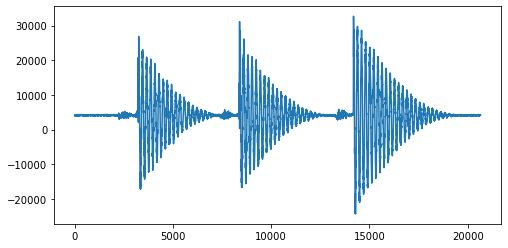

In [7]:
plt.figure(figsize=(8,4))
plt.plot(data[:,-1])
plt.show()

In [8]:
g=9.81
guncal=np.median(data[-1000:,-1])
calf=g/guncal
guncal,calf,0.061*4/1000

(4105.0, 0.002389768574908648, 0.000244)

In [9]:
condata=np.copy(data)
condata[:,0]=np.arange(len(condata[:,0]))/sf
condata[:,1]=(condata[:,1]-guncal)*calf
#condata[:,1]=(condata[:,1]-guncal)*0.061*4/1000

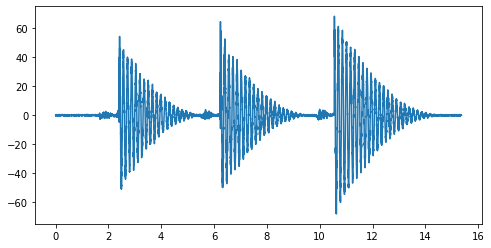

In [10]:
#data[:,-1] = data[:,-1] - np.median(data[-2000:,-1]) 

plt.figure(figsize=(8,4))
plt.plot(condata[:,0],condata[:,-1])
plt.show()

In [11]:
datauseful=condata[3250:4750,-1]
tstamps=np.arange(len(datauseful))/sf

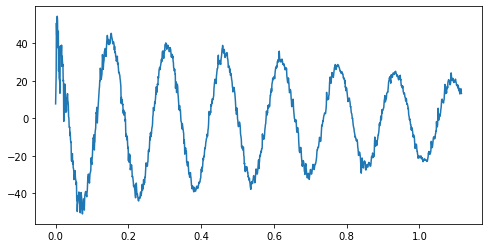

In [12]:
plt.figure(figsize=(8,4))
plt.plot(tstamps,datauseful)
plt.show()

In [13]:
def fint(x,fs,IS,lc=0):
    
    """
    Integrates a time domain signal IS times in the frequency domain.
    
    Input: (x,fs,IS,lc=0)
    Output: y
    """
    
    h = np.fft.fft(x)
    n = len(h)
    n2 = int(n/2)
    df = (fs/2)/n2
    nc = int(np.floor(lc/df+0.5))
    
    #if lc given:
    if lc != 0:
        h[0:nc+1] = np.linspace(0,0,nc+1)
        h[n-nc-1:n] = np.linspace(0,0,nc+1)

    w = (np.arange(n2+1)/n2*(fs*np.pi))
    w = np.append(w,-w[n2-1:0:-1])
    w[0] = 1
    j = 1j
    w = w * j
    g = h / (w**IS)
    y = np.fft.ifft(g)
    y = np.real(y)
    
    return y

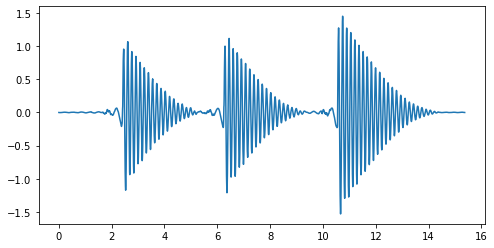

In [14]:
plt.figure(figsize=(8,4))
plt.plot(condata[:,0], fint(condata[:,-1],sf,1,3))
plt.show()

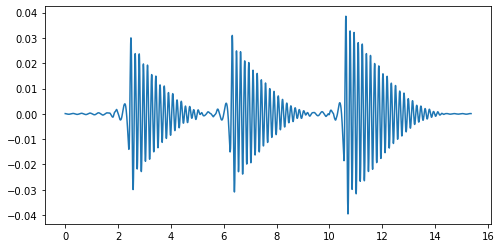

In [15]:
plt.figure(figsize=(8,4))
plt.plot(condata[:,0], fint(condata[:,-1],sf,2,3))
plt.show()

In [16]:
def FFT(time, signal):
    
    """
    FFT of a signal using NumPy
    
    Inputs: (time, signal)
    Outputs: (freqs, comp, mag, phase)
    """
    
    N=len(time)
    dt=time[1]-time[0]
    freqs=np.fft.fftfreq(N, d=dt)
    comp=np.fft.fft(signal)
    mag=np.abs(comp)*1/N
    phase=np.angle(comp)
    return freqs, comp, mag, phase

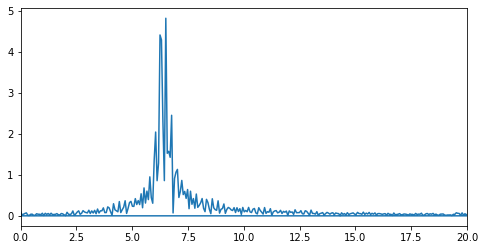

In [17]:
_=FFT(condata[:,0],condata[:,-1])
plt.figure(figsize=(8,4))
plt.plot(_[0],_[2])
plt.xlim(0,20)
plt.show()

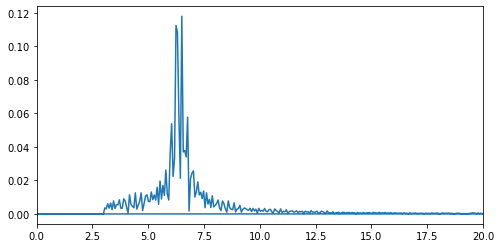

In [18]:
_=FFT(condata[:,0],fint(condata[:,-1],sf,1,3))
plt.figure(figsize=(8,4))
plt.plot(_[0],_[2])
plt.xlim(0,20)
plt.show()

In [19]:
#statically measured specific stiffness
kmeas=184.1
Mmeas=0.11211
(kmeas/Mmeas)**0.5/(2*np.pi)

6.44948221678872

In [20]:
import numpy as np
np.set_printoptions(linewidth=np.inf)
import sympy as sp
import scipy as sc
from colorednoise import powerlaw_psd_gaussian as cn
from scipy import integrate,signal,stats,io
from sklearn.linear_model import Lasso,ridge_regression
from sklearn.utils.extmath import weighted_mode

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

import pysindy as ps

from tqdm import tqdm,tnrange

import copy

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [21]:
from sindy_functions import *

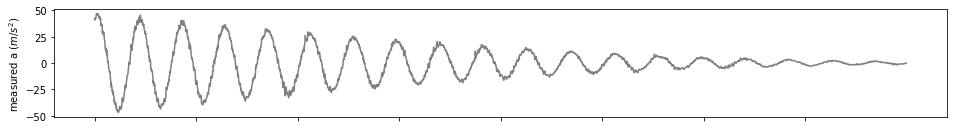

In [22]:
plt.figure(figsize=(16,2))
#plt.title("Raw measured acceleration")
plt.plot(condata[15000:19000,0], condata[15000:19000,1],'gray')
plt.ylabel('measured a ($m/s^2$)')
#plt.xticks([])
plt.xticks(condata[15000:19000,0][::500],['']*len(condata[15000:19000,0][::500]))
plt.show()

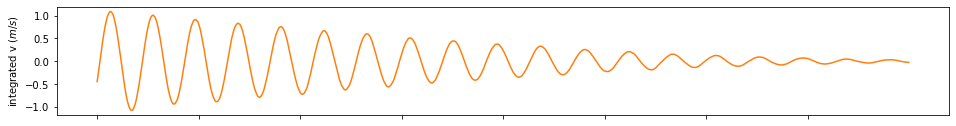

In [23]:
plt.figure(figsize=(16,2))
#plt.title("Raw measured acceleration")
plt.plot(condata[15000:19000,0], fint(condata[:,-1],sf,1,3)[15000:19000],'C1')
plt.ylabel('integrated v ($m/s$)')
#plt.xticks([])
plt.xticks(condata[15000:19000,0][::500],['']*len(condata[15000:19000,0][::500]))
plt.show()

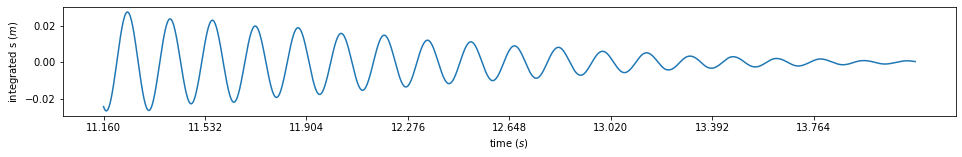

In [24]:
plt.figure(figsize=(16,2))
#plt.title("Raw measured acceleration")
plt.plot(condata[15000:19000,0], fint(condata[:,-1],sf,2,3)[15000:19000],'C0')
plt.ylabel('integrated s ($m$)')
plt.xlabel('time ($s$)')
#plt.xticks([])
plt.xticks(condata[15000:19000,0][::500])
plt.show()

In [26]:
uSol=np.vstack((fint(condata[:,-1],sf,2,3)[16000:19000],fint(condata[:,-1],sf,1,3)[16000:19000]))
#uSol=uSol.T
#uSol

In [27]:
uSoldt=np.gradient(uSol[:,:],1/sf,axis=1)

In [28]:
#STLSQ
deg=3
thres=0.9
mc=SINDy(polypool(uSol[:,:].T,deg),uSoldt.T,thres,reg=1e-16,normalise='auto')
names=polypool_names(['s','v'],deg)
dispmymod(mc,['s\'','v\''],names)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [29]:
#E-SINDy
incp=1-1e-16
mc=ESINDy(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,thres,100,0.632,1e-16,incp,normalise='auto')
names=polypool_names(['s','v'],deg)
dispmymod(mc,['s\'','v\''],names)

C:\Users\rautj\Desktop\MIR 2022\24September\mostFinalCode\jns\sindy_functions.py:585: RuntimeWarning: invalid value encountered in true_divide
  inc.append(np.nan_to_num(np.abs(mc/mc)))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [30]:
#STCV
mc,icv=SINDyCV_t(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,0.01,1e-16,1e-16,0.0,10,ptf=0.3,normalise='auto',reticv=True)
names=polypool_names(['s','v'],deg)
dispmymod(mc,['s\'','v\''],names)

C:\Users\rautj\Desktop\MIR 2022\24September\mostFinalCode\jns\sindy_functions.py:1120: RuntimeWarning: invalid value encountered in true_divide
  modelchange=np.any(np.nan_to_num(cterms/cterms)!=np.nan_to_num(nterms/nterms))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [31]:
#non-linear model

In [32]:
sourcefile='test0_8'

In [33]:
data=[]
with open(sourcefile+'.txt', newline='') as f:
    for line in f:
        data.append(line.strip().split(' '))
    #data = list(csv.reader(csvfile))

data=np.array(data)
data=np.delete(data,1,1)
#data=data.astype(float)

for _ in range(len(data[:,0])):
    #print(data[_,0])
    data[_,0]=get_sec(data[_,0])
    
data=data.astype(float)
print(data)

[[ 5.3160762e+07 -1.1200000e+02]
 [ 5.3160762e+07 -9.3000000e+01]
 [ 5.3160762e+07 -1.0000000e+02]
 ...
 [ 5.3168834e+07 -8.3000000e+01]
 [ 5.3168834e+07 -7.3000000e+01]
 [ 5.3168834e+07 -8.0000000e+01]]


In [34]:
if len(data)%2!=0:
    data=data[:-1]

In [35]:
sf=1/((data[-1,0]-data[0,0])/len(data[:,0])/1000)
print('sampling rate: '+str(sf))

sampling rate: 1437.0664023785926


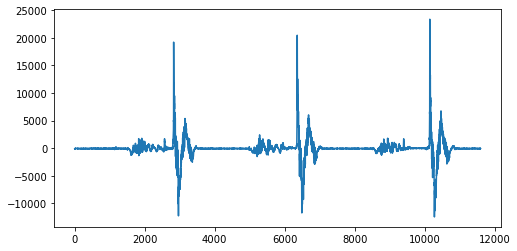

In [36]:
plt.figure(figsize=(8,4))
plt.plot(data[:,-1])
plt.show()

In [37]:
g=9.81
guncal=np.median(data[-1000:,-1])
calf=g/guncal
calf=9.81*0.061*4/1000
guncal,calf,0.061*4/1000

(-82.5, 0.00239364, 0.000244)

In [38]:
condata=np.copy(data)
condata[:,0]=np.arange(len(condata[:,0]))/sf
condata[:,1]=(condata[:,1]-guncal)*calf
#condata[:,1]=(condata[:,1]-guncal)*0.061*4/1000

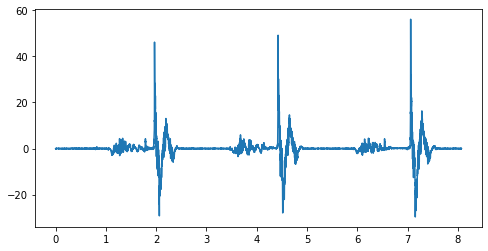

In [39]:
#data[:,-1] = data[:,-1] - np.median(data[-2000:,-1]) 

plt.figure(figsize=(8,4))
plt.plot(condata[:,0],condata[:,-1])
plt.show()

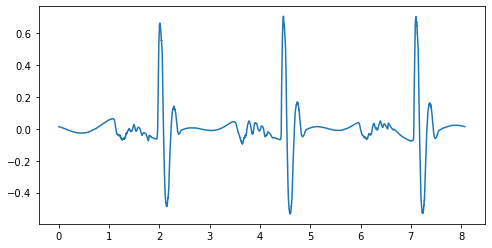

In [40]:
plt.figure(figsize=(8,4))
plt.plot(condata[:,0], fint(condata[:,-1],sf,1,0.7))
plt.show()

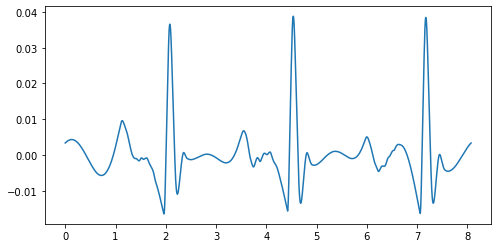

In [41]:
plt.figure(figsize=(8,4))
plt.plot(condata[:,0], fint(condata[:,-1],sf,2,0.7))
plt.show()

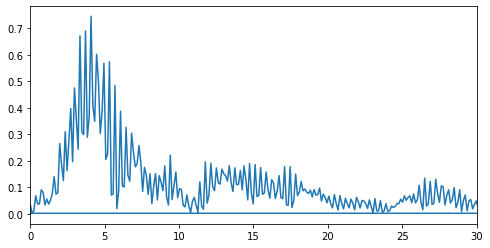

In [42]:
_=FFT(condata[:,0],condata[:,-1])
plt.figure(figsize=(8,4))
plt.plot(_[0],_[2])
plt.xlim(0,30)
plt.show()

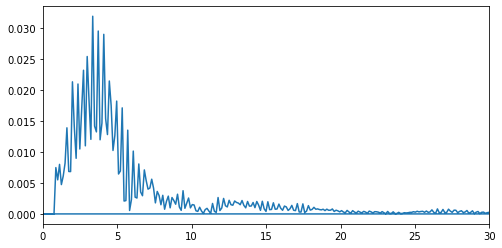

In [43]:
_=FFT(condata[:,0],fint(condata[:,-1],sf,1,0.7))
plt.figure(figsize=(8,4))
plt.plot(_[0],_[2])
plt.xlim(0,30)
plt.show()

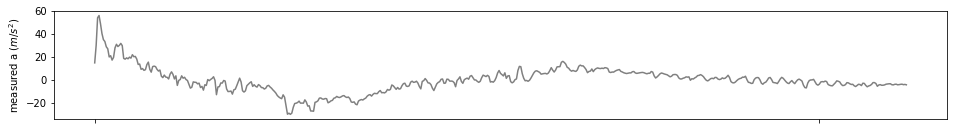

In [44]:
plt.figure(figsize=(16,2))
#plt.title("Raw measured acceleration")
plt.plot(condata[int(7.06*sf):int(7.45*sf),0], condata[int(7.06*sf):int(7.45*sf),1],'gray')
plt.ylabel('measured a ($m/s^2$)')
#plt.xticks([])
plt.xticks(condata[int(7.06*sf):int(7.45*sf),0][::500],['']*len(condata[int(7.06*sf):int(7.45*sf),0][::500]))
plt.show()

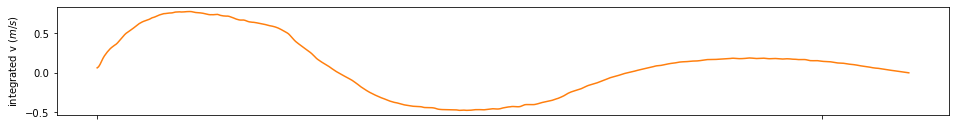

In [45]:
plt.figure(figsize=(16,2))
#plt.title("Raw measured acceleration")
plt.plot(condata[int(7.06*sf):int(7.45*sf),0], fint(condata[:,-1],sf,1,0.2)[int(7.06*sf):int(7.45*sf)],'C1')
plt.ylabel('integrated v ($m/s$)')
#plt.xticks([])
plt.xticks(condata[int(7.06*sf):int(7.45*sf),0][::500],['']*len(condata[int(7.06*sf):int(7.45*sf),0][::500]))
plt.show()

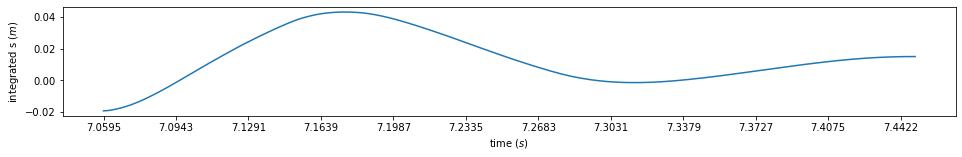

In [46]:
plt.figure(figsize=(16,2))
#plt.title("Raw measured acceleration")
plt.plot(condata[int(7.06*sf):int(7.45*sf),0], fint(condata[:,-1],sf,2,0.2)[int(7.06*sf):int(7.45*sf)],'C0')
plt.ylabel('integrated s ($m$)')
plt.xlabel('time ($s$)')
#plt.xticks([])
plt.xticks(condata[int(7.06*sf):int(7.45*sf),0][::50])
plt.show()

In [47]:
uSol=np.vstack((fint(condata[:,-1],sf,2,0)[int(7.06*sf):int(7.45*sf)],fint(condata[:,-1],sf,1,0)[int(7.06*sf):int(7.45*sf)]))
#uSol=uSol.T
#uSol

In [48]:
uSoldt=np.gradient(uSol[:,:],1/sf,axis=1)

In [49]:
#STLSQ
deg=3
thres=0.9
mc=SINDy(polypool(uSol[:,:].T,deg),uSoldt.T,thres,reg=1e-16,normalise='auto')
names=polypool_names(['s','v'],deg)
dispmymod(mc,['s\'','v\''],names)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [50]:
#E-SINDy
incp=1-1e-16
mc=ESINDy(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,thres,100,0.632,1e-16,incp,normalise='auto')
names=polypool_names(['s','v'],deg)
dispmymod(mc,['s\'','v\''],names)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [51]:
#STCV
mc,icv=SINDyCV_t_1(polypool_(uSol[:,:].T,deg),uSoldt[:,:].T,0.0,1e-1,1e-16,0.0,100,ptf=0.4,normalise='auto',reticv=True)
names=polypool_names_(['s','v'],deg)
dispmymod(mc,['s\'','v\''],names)
icv

C:\Users\rautj\Desktop\MIR 2022\24September\mostFinalCode\jns\sindy_functions.py:1200: RuntimeWarning: invalid value encountered in true_divide
  while np.nanmin((pp/pp)*np.abs(pp))<pt:
C:\Users\rautj\Desktop\MIR 2022\24September\mostFinalCode\jns\sindy_functions.py:1202: RuntimeWarning: invalid value encountered in true_divide
  mc[nanminidx_2d((pp/pp)*np.abs(pp))]=0


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ 0.00000000e+00, -1.75282991e+00],
       [ 0.00000000e+00, -9.34587899e-01],
       [ 1.01714731e+03, -9.59251975e-01],
       [ 0.00000000e+00, -5.78964895e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -6.24342155e-01],
       [ 0.00000000e+00,  0.00000000e+00]])

In [52]:
def nlscv(dis):
    
    return -0.11211*(-1360.26*dis-33094.72*dis**2-371947.09*dis**3)
def nlslsq(dis):
    
    return -0.11211*(-1653.2*dis-41718.39*dis**2-218332.31*dis**3)
def nlse(dis):
    
    return -0.11211*(-1567.36*dis-39480.1*dis**2-429447.2*dis**3)


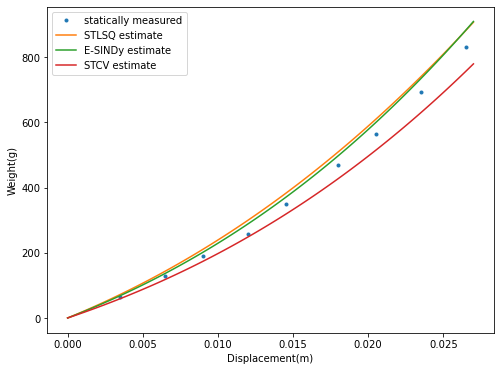

In [75]:
plt.figure(figsize=(8,6))
plt.ylabel('Weight(g)')
plt.xlabel('Displacement(m)')
plt.plot([0.0035, 0.0065, 0.0090, 0.0120, 0.0145, 0.0180, 0.0205, 0.0235, 0.0265],
         #1.1211 correction factor to account for 'sticking' during static testing
         np.array([58, 116, 170, 231, 312, 419, 504, 617, 742])*1.1211,'.',label='statically measured')
plt.plot(np.linspace(0,0.027,100),nlslsq(np.linspace(0,0.027,100))/9.81*1000,label='STLSQ estimate')
plt.plot(np.linspace(0,0.027,100),nlse(np.linspace(0,0.027,100))/9.81*1000,label='E-SINDy estimate')
plt.plot(np.linspace(0,0.027,100),nlscv(np.linspace(0,0.027,100))/9.81*1000,label='STCV estimate')
plt.legend()
plt.show()